In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.model_selection as skm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from ISLP import load_data, confusion_table

In [2]:
from sklearn.svm import SVC
from ISLP.svm import plot as plot_svm
from sklearn.metrics import RocCurveDisplay, accuracy_score

roc_curve = RocCurveDisplay.from_estimator

In [3]:
# Read in dataset
auto = pd.read_csv('Datasets/Auto.csv')
auto.info()
auto.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    int64  
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    int64  
 8   name          392 non-null    object 
dtypes: float64(3), int64(5), object(1)
memory usage: 27.7+ KB


(392, 9)

In [4]:
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


#### Use the attached ‘auto.csv’ data file to build a support vector machines model to determine whether a given car gets high or low gas mileage.
1. Create a binary variable that takes on a value of 1 for cars with gas mileage above the median and 0 for cars with gas mileage below the median.

In [5]:
# Find the median mpg
median_mpg = auto['mpg'].median()

# Create new binary column using median mpg (22.75)
auto['high_mileage'] = (auto['mpg'] > median_mpg).astype(int)

# Verify new column
print(auto[['high_mileage', 'mpg']].head(10))
print(auto[['high_mileage', 'mpg']].tail(10))

   high_mileage   mpg
0             0  18.0
1             0  15.0
2             0  18.0
3             0  16.0
4             0  17.0
5             0  15.0
6             0  14.0
7             0  14.0
8             0  14.0
9             0  15.0
     high_mileage   mpg
382             1  26.0
383             0  22.0
384             1  32.0
385             1  36.0
386             1  27.0
387             1  27.0
388             1  44.0
389             1  32.0
390             1  28.0
391             1  31.0


2. Fit a support vector classifier to the data using a linear kernel. Use a seed of 123, if needed. Experiment with different values of C to predict whether a car gets high or low gas mileage.

In [6]:
# Define features and target
X = auto.drop(columns = ['mpg', 'high_mileage', 'name'])
y = auto['high_mileage']

In [7]:
# Scale the features
scaler = StandardScaler()
# Use full dataset for cross val score
X_scaled = scaler.fit_transform(X)

In [8]:
# Fit svc, print with different C values
C_values = [0.01, 0.1, 1, 10, 100]

for C in C_values:
    svm = SVC(kernel='linear', C=C, random_state=123)
    scores = cross_val_score(svm, X_scaled, y, cv=5, scoring='accuracy')
    acc = scores.mean()
    print(f"C = {C}, Cross-Validated Accuracy: {acc:.4f}")

C = 0.01, Cross-Validated Accuracy: 0.9004
C = 0.1, Cross-Validated Accuracy: 0.8751
C = 1, Cross-Validated Accuracy: 0.8523
C = 10, Cross-Validated Accuracy: 0.8574
C = 100, Cross-Validated Accuracy: 0.8574


3. Report the cross-validation errors associated with different values of this parameter. Discuss the empirical implications of those results.

In [9]:
# Parameter grid
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

# 5-fold cross val
cv = KFold(n_splits=5, shuffle=True, random_state=123)

# Initialize SVM
svm_linear = SVC(kernel='linear')

# Grid search
grid = GridSearchCV(estimator=svm_linear,
                    param_grid=param_grid,
                    cv=cv,
                    scoring='accuracy',
                    return_train_score=True)

grid.fit(X_scaled, y)

# Error
results_df = pd.DataFrame({
    'C': param_grid['C'],
    'CV Error': 1 - grid.cv_results_['mean_test_score']
})

results_df


,C,CV Error
0,0.01,0.084096
1,0.10,0.094288
2,1.00,0.081467
3,10.00,0.083999
4,100.00,0.089127


The cross validation error is lowest for C = 1 around ~8.1%. This suggests this model has the best performance among the models tested.
Smaller C values (like 0.1) result in slightly higher error, possibly due to underfitting.
Increasing C above 1 yields higher error, indicating a plateau in model improvement at C = 1.

4. Now repeat Q2, this time using SVMs with radial and polynomial basis kernels, with different values of gamma and degree and C. Discuss the empirical
implications of those results.

In [10]:
# Param grid
param_grid_rbf = {
    'C':[0.1, 1, 10, 100, 1000],
    'gamma':[0.5, 1, 2, 3, 4]
}

# Initialize SVM rbf
svm_rbf = SVC(kernel='rbf')

# Grid search
grid_rbf = GridSearchCV(svm_rbf, param_grid_rbf, cv=cv, scoring='accuracy')
grid_rbf.fit(X_scaled, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
             estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [0.5, 1, 2, 3, 4]},
             scoring='accuracy')

In [11]:
# Results
results_rbf = pd.DataFrame(grid_rbf.cv_results_)

# Add cross val error
results_rbf['CV Error'] = 1 - results_rbf['mean_test_score']

# Top 5 by cross val error
results_rbf[['param_C', 'param_gamma', 'mean_test_score', 'CV Error']].sort_values(by='CV Error', ascending=True).head()

,param_C,param_gamma,mean_test_score,CV Error
6,1.0,1.0,0.923694,0.076306
5,1.0,0.5,0.921097,0.078903
8,1.0,3.0,0.918598,0.081402
11,10.0,1.0,0.918468,0.081532
7,1.0,2.0,0.916099,0.083901


In [12]:
# Param grid
param_grid_poly = {
    'C':[0.1, 1, 10, 100, 1000],
    'degree': [2, 3, 4]
}

# initialize SVM poly
svm_poly = SVC(kernel='poly')

# Grid Search
grid_poly = GridSearchCV(svm_poly, param_grid_poly, cv=cv, scoring='accuracy')
grid_poly.fit(X_scaled, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
             estimator=SVC(kernel='poly'),
             param_grid={'C': [0.1, 1, 10, 100, 1000], 'degree': [2, 3, 4]},
             scoring='accuracy')

In [13]:
# DF of results
results_poly = pd.DataFrame(grid_poly.cv_results_)

# Add cross val error
results_poly['CV Error'] = 1 - results_poly['mean_test_score']

# Top 5 by cross val error
results_poly[['param_C', 'param_degree', 'mean_test_score', 'CV Error']].sort_values(by='CV Error', ascending=True).head()

,param_C,param_degree,mean_test_score,CV Error
7,10.0,3,0.926095,0.073905
10,100.0,3,0.918565,0.081435
4,1.0,3,0.898150,0.101850
13,1000.0,3,0.895521,0.104479
11,100.0,4,0.857319,0.142681


In [14]:
# Comparison of all kernels using bestscore/bestparams
summary = pd.DataFrame({
    'Kernel': ['Linear', 'RBF', 'Polynomial'],
    'Best CV Accuracy': [
        grid.best_score_,
        grid_rbf.best_score_,
        grid_poly.best_score_
    ],
    'Best Params': [
        grid.best_params_,
        grid_rbf.best_params_,
        grid_poly.best_params_
    ]
})

summary

,Kernel,Best CV Accuracy,Best Params
0,Linear,0.918533,{'C': 1}
1,RBF,0.923694,"{'C': 1, 'gamma': 1}"
2,Polynomial,0.926095,"{'C': 10, 'degree': 3}"


The Polynomial kernel achieved the highest cross validation accuracy at 92.61%, performing better than the the RBF and linear kernels.
The linear kernel came close at 91.85% accuracy.
These results suggest that introducing non-linearity through polynomial or RBF kernels may yield improvements in classification performance for the dataset.

5. Generate relevant plots to support your findings in Q2 and Q4.

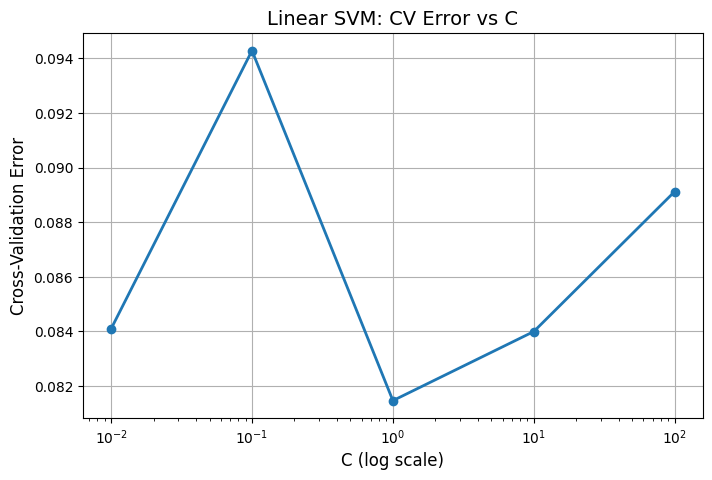

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(results_df['C'], results_df['CV Error'], marker='o', linestyle='-', linewidth=2)
plt.xscale('log')
plt.xlabel('C (log scale)', fontsize=12)
plt.ylabel('Cross-Validation Error', fontsize=12)
plt.title('Linear SVM: CV Error vs C', fontsize=14)
plt.grid(True)
plt.show()

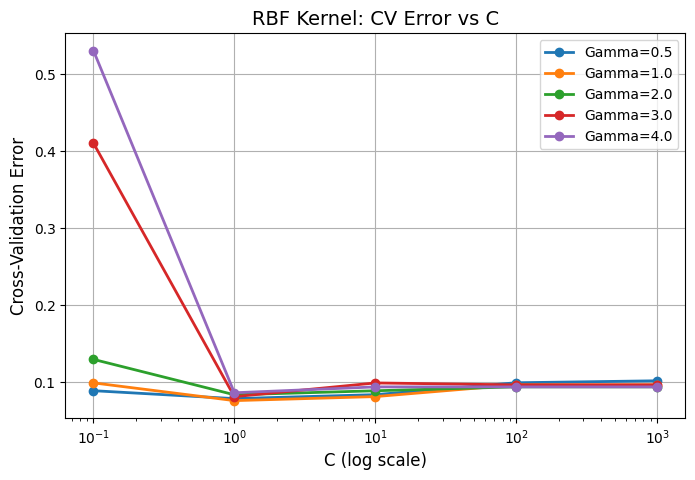

In [17]:
rbf_df = results_rbf.copy()
rbf_df['C'] = rbf_df['param_C']
rbf_df['Gamma'] = rbf_df['param_gamma']

plt.figure(figsize=(8, 5))
for gamma in sorted(rbf_df['Gamma'].unique()):
    subset = rbf_df[rbf_df['Gamma'] == gamma]
    plt.plot(subset['C'], subset['CV Error'], marker='o', linestyle='-', linewidth=2, label=f'Gamma={gamma}')
plt.xscale('log')
plt.xlabel('C (log scale)', fontsize=12)
plt.ylabel('Cross-Validation Error', fontsize=12)
plt.title('RBF Kernel: CV Error vs C', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

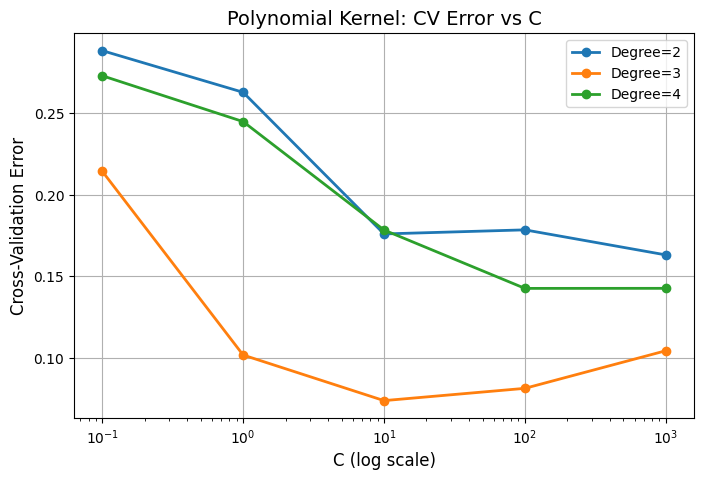

In [18]:
poly_df = results_poly.copy()
poly_df['C'] = poly_df['param_C']
poly_df['Degree'] = poly_df['param_degree']

plt.figure(figsize=(8, 5))
for degree in sorted(poly_df['Degree'].unique()):
    subset = poly_df[poly_df['Degree'] == degree]
    plt.plot(subset['C'], subset['CV Error'], marker='o', linestyle='-', linewidth=2, label=f'Degree={degree}')
plt.xscale('log')
plt.xlabel('C (log scale)', fontsize=12)
plt.ylabel('Cross-Validation Error', fontsize=12)
plt.title('Polynomial Kernel: CV Error vs C', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()
